In [ ]:
import pandas_datareader as web
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client
from dask.distributed import as_completed
import pandas_market_calendars as mcal
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

from dask.distributed import Client
from dask.distributed import as_completed

pd.set_option("max_rows", 10)

In [ ]:
sp500 = web.DataReader("^GSPC", "yahoo")
vix = web.DataReader("VIXCLS","fred")
T10Y3M = web.DataReader("T10Y3M","fred")
FEDFUNDS = web.DataReader("FEDFUNDS","fred")


In [ ]:
tickers = ['^FTSE', '^N225', '^GDAXI', '^FCHI', '^HSI', '^BVSP',
                   '^RUT', 'IXY', 'IXR', 'IXE', 'IXM', 'IXV', 'IXT',
                   'IXB', 'IXU', '^IRX', '^FVX', '^TNX', '^TYX', 'VWEHX',
                   'VFSTX', 'VWESX']

"""
def process_data(ticker):
    df = web.DataReader(ticker, "yahoo")
    return(df)

client = Client('192.168.3.100:8786',timeout=3)

future_ = client.map(process_data,tickers)
results = list()

for f in as_completed(future_):
        if(f.status=="error"):
            results.append("error")
        else:
            results.append(f.result())     

client.close()
"""

In [ ]:
nyse = mcal.get_calendar('NYSE')
early = nyse.schedule(start_date=sp500.index[0].strftime('%Y-%m-%d'), end_date=sp500.index[-1].strftime('%Y-%m-%d'))

In [ ]:
#ax2=ax.twinx()

# create figure and axis objects with subplots()
fig,ax2=plt.subplots()

ax2.plot(T10Y3M.index,T10Y3M.replace([np.inf, -np.inf], 0))
#plt.set_xlabel("T10Y3M")
ax2.set_ylabel("T10Y3M")
#ax2.set_ylabel("lifeExp")


ax2.plot(T10Y3M.index,T10Y3M.pct_change().replace([np.inf, -np.inf]))
#ax.set_xlabel("10Y3M-Delta")
plt.show()


In [ ]:
newData = pd.concat([vix.reindex(early.index),T10Y3M.reindex(early.index),sp500.reindex(early.index)['Adj Close'],FEDFUNDS.reindex(early.index)],axis=1).interpolate(method='time')

In [ ]:
newData.corr()

In [ ]:
newDataDelta = newData.pct_change().replace([np.inf, -np.inf], 0).dropna()
newDataDelta.corr()

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot

# make a plot with different y-axis using second axis object
#ax2.plot(sp500.index, sp500['Adj Close'].diff(), marker=".",color="yellow")
ax.plot(newDataDelta.index, newDataDelta['Adj Close'].pct_change(), marker=".",color="blue")
ax.set_ylabel("SP500",color="blue",fontsize=8)

ax3=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(sp500.index, sp500['Adj Close'].diff(), marker=".",color="yellow")
ax3.plot(newDataDelta.index, newDataDelta['T10Y3M'].pct_change(), marker=".",color="green")
ax3.set_ylabel("T10Y3M",color="green",fontsize=8)
plt.show()

fig,ax = plt.subplots()
# make a plot

# make a plot with different y-axis using second axis object
#ax2.plot(sp500.index, sp500['Adj Close'].diff(), marker=".",color="yellow")
ax.plot(newDataDelta.index, newDataDelta['Adj Close'].pct_change(), marker=".",color="blue")
ax.set_ylabel("SP500",color="blue",fontsize=8)

ax2=ax.twinx()

ax2.plot(newDataDelta.index, newDataDelta['VIXCLS'].pct_change(), marker=".", color="red")
# set x-axis label
#ax.set_xlabel("year",fontsize=14)
# set y-axis label
ax2.set_ylabel("VIX",color="red",fontsize=8)

plt.show()



#plt.scatter(newDataDelta['Adj Close'].pct_change(),newDataDelta['T10Y3M'].pct_change())
#plt.show()

In [ ]:
newDataDelta.columns

In [ ]:

scores = []

corrscores = []

scores = []

def compare_x_lag_y(npa_):
                
    k_=10

    cv_outer = KFold(n_splits=k_, shuffle=False)
    cv_inner = KFold(n_splits=k_, shuffle=False)

    i = npa_[0]
    sp500_ = npa_[1]
    vix_ = npa_[2]
    formula = npa_[3]
    
    #default
    if(formula==0):
        combined = pd.concat([vix_.reindex(early.index),sp500_.reindex(early.index)['Adj Close'].shift(i)],axis=1).interpolate(method='time').dropna()
    #sp500 differenced twice
    if(formula==1):
        combined = pd.concat([vix_.reindex(early.index),sp500_.reindex(early.index)['Adj Close'].pct_change().shift(i)],axis=1).interpolate(method='time').dropna()
        

    corrscores.append(combined.corr())
    
    X=combined[['VIXCLS']]
    y=combined[['Adj Close']]

    outer_results = list()

    for trainv_ix, test_ix in cv_outer.split(X):
        # split data
        X_trainv, X_test = X.iloc[trainv_ix], X.iloc[test_ix, :]
        y_trainv, y_test = y.iloc[trainv_ix], y.iloc[test_ix]

        inner_results = list()
        inner_models = list()

        #good juncture to fork locally
        for train_ix, valid_ix in cv_inner.split(X_trainv):
            # split data
            X_train, X_valid = X_trainv.iloc[train_ix, :], X_trainv.iloc[valid_ix, :]
            y_train, y_valid = y_trainv.iloc[train_ix], y_trainv.iloc[valid_ix]
            model = LinearRegression()
            #just getting hyper-parm's (fit)
            lm = model.fit(X_train,y_train)
            inner_models.append(lm)

            #print(pd.concat([X_train,y_train],axis=1).corr())
            #print(lm.coef_)
            #yhat = gam.predict(X_valid[t])
            # evaluate the model
            #acc = np.mean(abs(y_valid.values.ravel()-yhat))
            # store the result
            #inner_results.append(acc)

        #good juncture to fork locally
        model_scores = list()

        #test inner model as ansemble
        for m in inner_models:
            model_scores.append(np.mean(abs(m.predict(X_test)-y_test.values.ravel())))

        #average internal model results and report as outer_result which*
        outer_results.append(np.mean(np.abs(model_scores)))

        #print('I Accuracy: %.3f (%.3f)' % (mean(inner_results), std(inner_results)))

    #*will in turn be averaged over all folds to determine that combination of term's outer score (real world performance, which will be our model evaluating metric).
    score = [np.mean(outer_results), np.std(outer_results)]
    #scores.append(([i,score]))
    return([i,score])
    
#for i in range(-92,92,1):


In [ ]:
npa0 = []

for t in range(-92,0,1):
    npa0.append([t,newDataDelta[['Adj Close']],newDataDelta[['VIXCLS']],0])
#print(npa)

compare_x_lag_y(npa0[0])

client0 = Client('192.168.3.100:8786')
#client.restart()

future0 = client0.map(compare_x_lag_y, npa0)

results0 = client0.gather(future0)

plt.plot(pd.DataFrame([r[1][0] for r in results0]).set_index(np.array(range(-92,0,1))))
plt.show()


In [ ]:
results0

In [ ]:
np.array(range(-92,0,1))

In [ ]:
len(range(-92,0,1))

In [ ]:
lag = range(-92,0,1)[np.argmin([r[1][0] for r in results0])]

In [ ]:
npa1 = []

#differenced y (twice)
for t in range(-92,1,1):
    npa1.append([t,newDataDelta[['Adj Close']],newDataDelta[['VIXCLS']],1])
#print(npa)

client1 = Client('192.168.3.100:8786')
#client.restart()

future1 = client1.map(compare_x_lag_y, npa1)

results1 = client1.gather(future1)

plt.plot(pd.DataFrame([r[1][0] for r in results1]).set_index(np.array(range(-92,1,1))))
plt.show()


In [ ]:
"""
plt.plot([abs(c.values[0][1]) for c in corrscores])
#plt.xticks(range(-92,92,1),[c.values[0][1] for c in corrscores], rotation=45)
plt.show()
range(-92,92,1)[np.argmax([abs(c.values[0][1]) for c in corrscores])]
"""

In [ ]:
#pd.concat([vix.reindex(early.index),sp500.reindex(early.index)['Adj Close'].pct_change().shift(range(-92,92,1)[np.argmin([s[1][0] for s in scores])])],axis=1).interpolate(method='time').dropna().corr()

In [44]:
combined = pd.concat([newDataDelta[['VIXCLS']],newDataDelta[['Adj Close']].shift(lag)],axis=1).dropna()
model = LinearRegression(fit_intercept=True)
#just getting hyper-parm's (fit)
lm = model.fit(combined[['VIXCLS']],combined[['Adj Close']])
print(lm.intercept_)
print(lm.coef_)

[0.00046398]
[[0.01097137]]


array([0.00433178])

In [41]:
#dir(lm)

In [ ]:
y

In [48]:

#X = sm.add_constant(pd.concat([newDataDelta[['VIXCLS']],newDataDelta[['Adj Close']].shift(lag)],axis=1).dropna())[['VIXCLS']]
X = sm.add_constant(combined[['VIXCLS']])
y = combined[['Adj Close']]
results = sm.OLS(y,X).fit()
results.summary()  



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.180
Date:                Fri, 06 May 2022   Prob (F-statistic):            0.00431
Time:                        02:48:54   Log-Likelihood:                 3651.7
No. Observations:                1239   AIC:                            -7299.
Df Residuals:                    1237   BIC:                            -7289.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.283      0.200      -0.000       0.001
VIXCLS         0.0110      0.004      2.860      0.004       0.003       0.018
==============================================================================
Omnibus:                      376.786   Durbin-Watson:                   2.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13480.588
Skew:                          -0.711   Prob(JB):                         0.00
Kurtosis:                      19.097   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adj Close    0.000515
dtype: float64

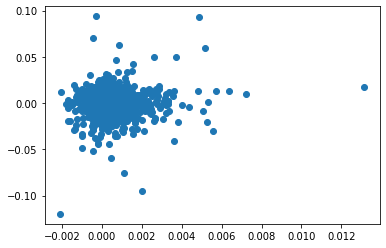

In [47]:
plt.scatter(results.predict(X),y)